# Inserting Libraries and Data

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns # alternative for plotting data
import pickle

from sklearn.preprocessing import StandardScaler
from hdbscan import HDBSCAN

In [47]:
df = pd.read_csv('NIST_Roof.csv')

df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

df.set_index('TIMESTAMP', inplace = True)


array([<Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>, <Axes: xlabel='TIMESTAMP'>,
       <Axes: xlabel='TIMESTAMP'>], dtype=object)

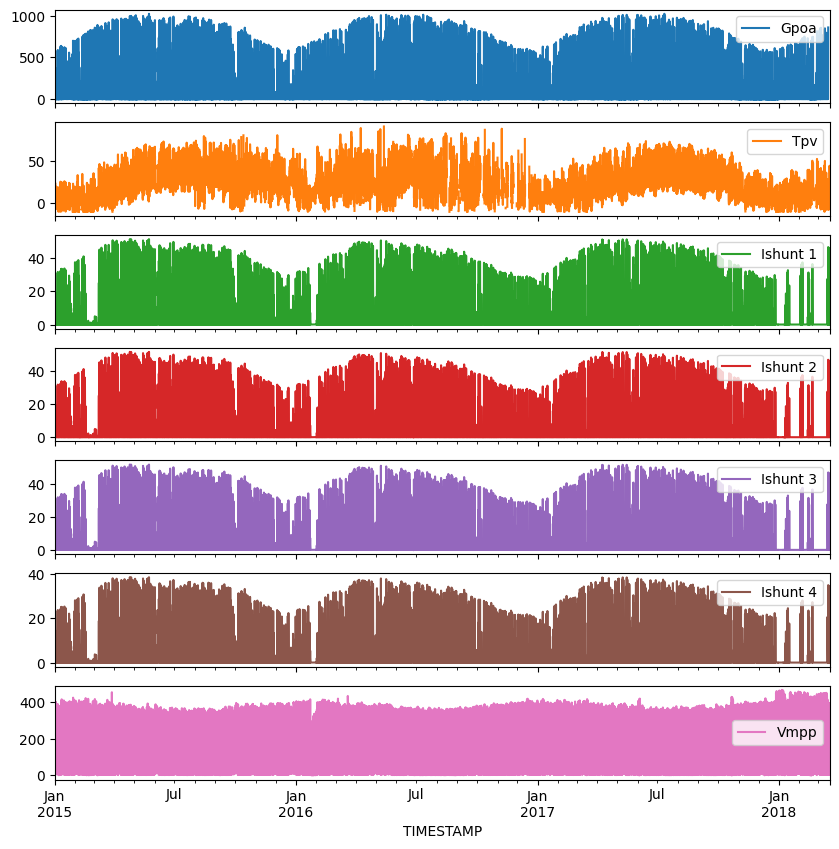

In [48]:
df.loc[df['Gpoa'] < 0, 'Gpoa'] = np.nan

df.loc[(df['Tpv'] < -10) | (df['Tpv'] > 90) , 'Tpv'] = np.nan

for i in range(1, 5):
    df.loc[df[f'Ishunt {i}'] < 0, f'Ishunt {i}'] = 0

df.loc[df[f'Vmpp'] < 0, f'Vmpp'] = 0

df.resample('1H').mean().plot(subplots = True, figsize = (10, 10))




In [49]:
for i in range(1, 5):
    df[f'P_{i}'] = df[f'Ishunt {i}'] * df['Vmpp']

# Developing the PV output estimation model

## Data filltering for training PV output estimation models

We need to preserve the good data and remove the data containing abnormalities and non expected behaviors from the PV system. We have two filters:
- Daily pearson r between $I_{MPP}$ and $G_{PoA}$
- Daily $PR_{I}$

[(0.0, 1.1)]

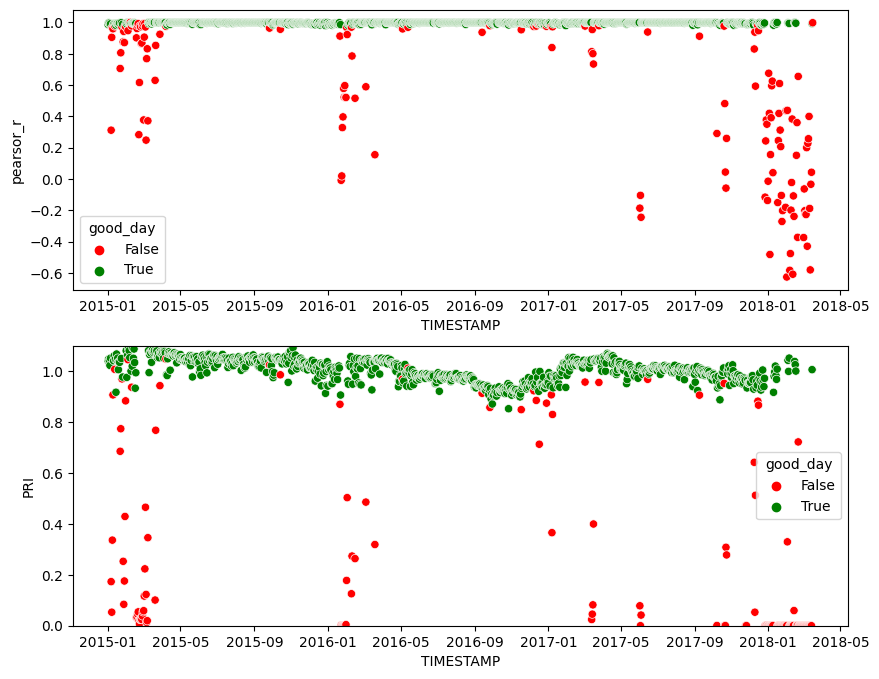

In [50]:
# Pearson r filter

target_current = 'Ishunt 1'
threshold_pearson_r = 0.98
PRI_threshold = (0.75, 1.25)

df_daily_filter = df.resample('1D').apply(lambda x: x[['Gpoa', target_current]].corr().iloc[0,1]).to_frame('pearsor_r')

df_daily_filter['good_pearson_r'] = df_daily_filter['pearsor_r'] > threshold_pearson_r

df_PRI = df[['Gpoa', target_current]].resample('D').sum()
df_PRI['PRI'] = df_PRI[target_current] / df_PRI['Gpoa']

df_PRI.drop(columns = ['Gpoa', target_current], inplace = True)

df_PRI = df_PRI / df_PRI.median()

df_daily_filter['PRI'] = df_PRI['PRI']
df_daily_filter['good_PRI'] = (df_daily_filter['PRI'] > PRI_threshold[0]) & (df_daily_filter['PRI'] < PRI_threshold[1])

df_daily_filter['good_day'] = df_daily_filter['good_PRI'] & df_daily_filter['good_pearson_r']

df_daily_filter

fig, ax = plt.subplots(2, figsize = (10, 8))

sns.scatterplot(data = df_daily_filter, x = df_daily_filter.index, y = 'pearsor_r', hue = 'good_day', palette= {True: 'green', False: 'red'}, ax = ax[0])

sns.scatterplot(data = df_daily_filter, x = df_daily_filter.index, y = 'PRI', hue = 'good_day', palette= {True: 'green', False: 'red'}, ax = ax[1])

ax[1].set(ylim = (0, 1.1))

In [51]:
def get_good_days_list(target_current, pearson_r_threshold = 0.98, PRI_thresholds = (0.75, 1.25)):
    df_daily_filter = df.resample('D').apply(lambda x: x[['Gpoa', target_current]].corr().iloc[0, 1]).to_frame(name='pearson_r')
    df_PRI = df[['Gpoa', target_current]].resample('D').sum()
    df_PRI['PRI'] = df_PRI[target_current] / df_PRI['Gpoa']
    df_PRI['PRI'] = df_PRI['PRI'] / df_PRI['PRI'].median()
    df_daily_filter['PRI'] = df_PRI['PRI']
    df_daily_filter['good_pearson_r'] = df_daily_filter['pearson_r'] > pearson_r_threshold
    df_daily_filter['good_PRI'] = (df_daily_filter['PRI'] > PRI_thresholds[0]) & (df_daily_filter['PRI'] < PRI_thresholds[1])
    df_daily_filter['good_day'] = df_daily_filter['good_pearson_r'] & df_daily_filter['good_PRI']
    good_days_list = df_daily_filter.index[df_daily_filter['good_day']].to_list()
    return good_days_list

good_days_dict = {}

for i in range(1, 5):
    good_days_dict[f'Ishunt {i}'] = get_good_days_list(f'Ishunt {i}')


In [ ]:
training_data_dict = {}
input_data_columns = ['Gpoa', 'Tpv']

for i in range(1, 5):
    target_value = f'Ishunt {i}'
    df_target = df[[target_value] + input_data_columns].loc['2015']

    df_target['date'] = pd.to_datetime(df_target.index.date)
    df_target = df_target.loc[df_target['date'].isin(good_days_dict[target_value])].drop(columns = 'date').dropna()
    
    training_data_dict[target_value] = df_target

target_value = 'Vmpp'

common_good_days = set(good_days_dict['Ishunt 1']).intersection(set(good_days_dict['Ishunt 2'])).intersection(set(good_days_dict['Ishunt 3'])).intersection(set(good_days_dict['Ishunt 4']))
common_good_days = np.sort(list(common_good_days))

df_target = df[[target_value] + input_data_columns].loc['2015']
df_target['date'] = pd.to_datetime(df_target.index.date)
df_target = df_target.loc[df_target['date'].isin(common_good_days)].drop(columns = 'date').dropna()
training_data_dict[target_value] = df_target


### Scaling the input data

Bring the input values in the same ranges (0-1) so the ML model understands better the correlations and perform better.

In [ ]:
scalers = {}
scaled_training_data_dict = {}

for key, df_train in training_data_dict.items():
    scaler = StandardScaler()
    X = df_train[input_data_columns]
    X_scaled = scaler.fit_transform(X)
    scaled_training_data = df_train.copy()
    scaled_training_data[input_data_columns] = X_scaled
    scaled_training_data_dict[key] = scaled_training_data.copy()
    scalers[key] = scaler

### Model training part
Training the models using deep learning.

In [ ]:
from sklearn.neural_network import MLPRegressor

models = {}

model_parms = {
    'hidden_layer_sizes': (20, ),
    'activation': 'relu',
    'learning_rate_init': 0.01,
    'tol': 0.5,
    'early_stopping': True,
    'n_iter_no_change': 20,}


[Text(0.5, 0, 'Iterations'), Text(0, 0.5, 'Loss')]

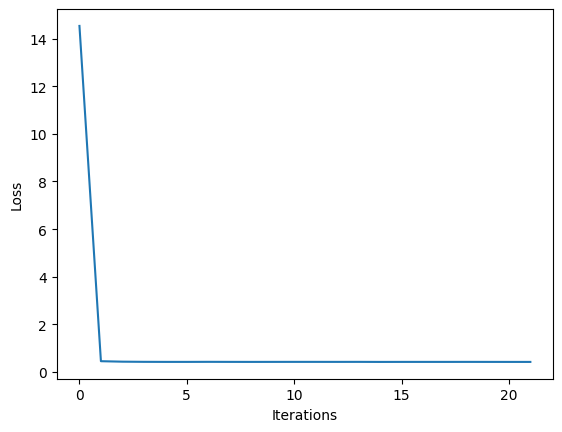

In [10]:
target_value = f'Ishunt 1'

X = scaled_training_data_dict[target_value][input_data_columns]
y = scaled_training_data_dict[target_value][target_value]

models[target_value] = MLPRegressor(**model_parms)
models[target_value].fit(X, y)

fig, ax = plt.subplots()

ax.plot(models[target_value].loss_curve_)

ax.set(xlabel = 'Iterations', ylabel = 'Loss')

c:\Users\u0148831\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


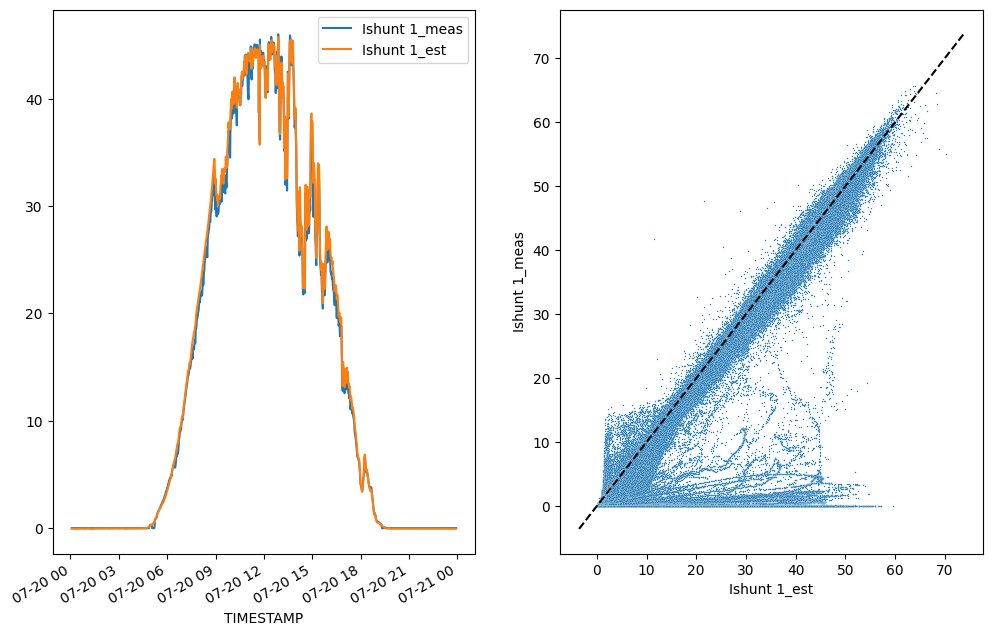

In [11]:
target_value = f'Ishunt 1'

df_test = df[input_data_columns].dropna()

scaler = scalers[target_value]

X_input = scaler.transform(df_test)

y_hat = models[target_value].predict(X_input)

df_test[f'{target_value}_est'] = y_hat
df_test[f'{target_value}_meas'] = df[target_value]

fig, ax = plt.subplots(1, 2, figsize = (12, 8))

date = '2017-07-20'

df1 = df_test.loc[date].copy()

df1[[f'{target_value}_meas', f'{target_value}_est']].plot(ax = ax[0])

sns.scatterplot(data = df_test, x =f'{target_value}_est', y = f'{target_value}_meas', ax = ax[1], s = 1)

xr = np.linspace(*ax[1].get_xlim(), 10)

ax[1].plot(xr, xr, c = 'black', linestyle = '--')

In [12]:

import xgboost


target_value = 'Vmpp'

X = scaled_training_data_dict[target_value][input_data_columns]
y = scaled_training_data_dict[target_value][target_value]

models[target_value] = xgboost.XGBRegressor()

models[target_value].fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

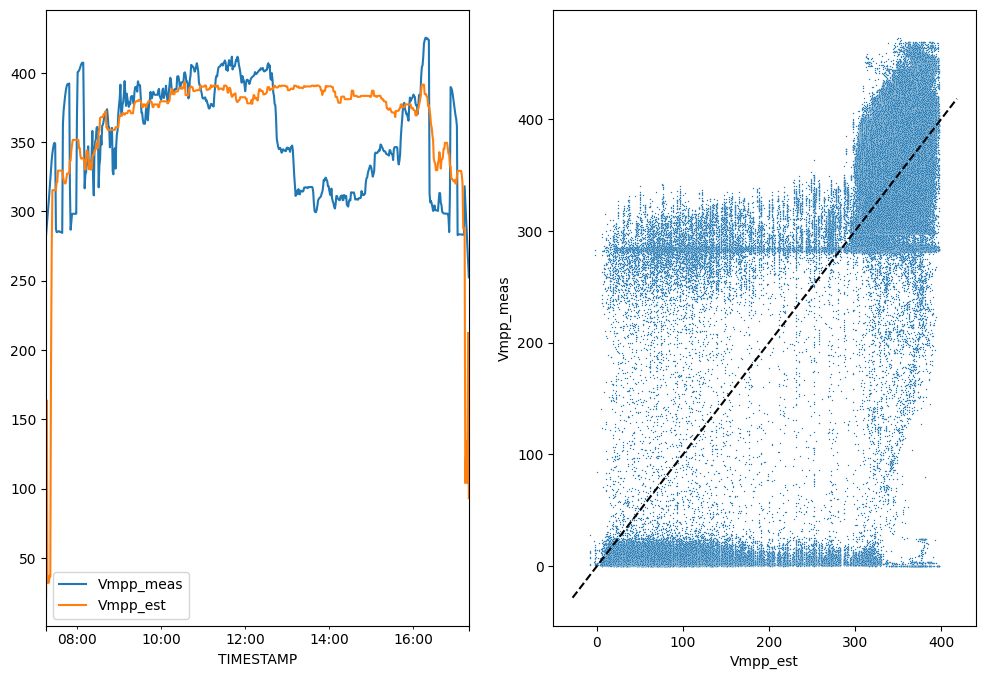

In [ ]:
target_value = f'Vmpp'

df_test = df[input_data_columns].dropna()

scaler = scalers[target_value]

X_input = scaler.transform(df_test)

y_hat = models[target_value].predict(X_input)

df_test[f'{target_value}_est'] = y_hat
df_test[f'{target_value}_meas'] = df[target_value]

fig, ax = plt.subplots(1, 2, figsize = (12, 8))

date = '2017-1-5'

df1 = df_test.loc[date].copy()

df1[[f'{target_value}_meas', f'{target_value}_est']].plot(ax = ax[0])

sns.scatterplot(data = df_test, x =f'{target_value}_est', y = f'{target_value}_meas', ax = ax[1], s = 1)

xr = np.linspace(*ax[1].get_xlim(), 10)

ax[1].plot(xr, xr, c = 'black', linestyle = '--')

In [14]:
# with open('seminar_models.pkl', 'wb') as f:
#     pickle.dump(models, f)

In [52]:
with open('seminar_models.pkl', 'rb') as f:
    models = pickle.load(f)

# Fault detection

We will udertake the following steps:
- Make Predictions
- Calculate ratios

In [53]:
def get_estimations(inputs, scaler, model):
    X_scaled = scaler.transform(inputs)
    return model.predict(X_scaled)

df_inputs = df[input_data_columns].dropna()
df_predictions = pd.DataFrame(index = df_inputs.index)

for target_value in models.keys():
    df_predictions[target_value] = get_estimations(df_inputs, scaler=scalers[target_value], model= models[target_value])

df_ratios = pd.concat([(df[target_value] / df_predictions[target_value]).to_frame(target_value) for target_value in models.keys()], axis = 1).dropna()
df_power_ratios = pd.DataFrame(index = df_ratios.index)

for i in range(1, 5):
    df_power_ratios[f'PI_{i}'] = df_ratios[f'Ishunt {i}'] * df_ratios['Vmpp']




c:\Users\u0148831\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\u0148831\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\u0148831\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
c:\Users\u0148831\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


### Determine threshold

Specify the threshold that below that value, the data are classsified as anomaly.

To do this, we should remove days contating errors using the same filters as we used for the training data and remove low irradiance data where the ratios have non linear behaviour

In [54]:
df_good_power_ratio_dates = df_power_ratios.copy()

df_good_power_ratio_dates['date'] = pd.to_datetime(df_good_power_ratio_dates.index.date)

df_good_power_ratio_dates = df_good_power_ratio_dates.loc[df_good_power_ratio_dates['date'].isin(common_good_days)]

df_good_power_ratio_dates['Gpoa'] = df['Gpoa']

df_good_power_ratio_dates = df_good_power_ratio_dates.query('Gpoa > 200')

PI_thresholds = {i : df_good_power_ratio_dates[f'PI_{i}'].median() - 2 * df_good_power_ratio_dates[f'PI_{i}'].std() for i in range(1, 5)}


### Identify anlomalies and faults

Anomalies are ratios below the thresholds for $G_{PoA}$ > 200 W/m²

Faults are anomalies lasting more than 2 hours

In [56]:
df_power_ratios_anomalies = df_power_ratios.copy()

df_power_ratios_anomalies['Gpoa'] = df['Gpoa']

df_power_ratios_anomalies = df_power_ratios_anomalies.query('Gpoa > 200').drop(columns = 'Gpoa')

for i in range(1, 5):
    df_power_ratios_anomalies[f'PI_{i}'] = df_power_ratios_anomalies[f'PI_{i}'] < PI_thresholds[i]


data_resolution = np.median(np.diff(df.index))
fault_duration_threshold = pd.Timedelta(hours = 2)

fault_timestamps = {}

for i in range(1, 5):
    df_alert = (df_power_ratios[[f'PI_{i}']] < PI_thresholds[i]).query(f'PI_{i} == True')
    downtime = df_alert.resample('1D').sum() * data_resolution > fault_duration_threshold
    fault_elegible_days = downtime.query(f'PI_{i} == True').index

    df_alert['date'] = pd.to_datetime(df_alert.index.date)
    fault_timestamps[i] = df_alert.loc[df_alert['date'].isin(fault_elegible_days)].index

# df_power_ratios_anomalies.resample('D').sum()

# Fault signature formulation

In [58]:
fault_signatures_dict = {}

for i in range(1, 5):
    fault_signatures_dict[i] = df_ratios.loc[df_ratios.index.isin(fault_timestamps[i])][[f'Ishunt {i}', 'Vmpp']].copy()

In [59]:
fault_signatures_dict[1].loc['2017-01-05']

,Ishunt 1,Vmpp
TIMESTAMP,,
2017-01-05 07:16:00,0.000000,13.382360
2017-01-05 07:17:00,0.000000,1.769764
2017-01-05 07:18:00,0.011153,9.237997
2017-01-05 07:19:00,0.011078,9.435016
2017-01-05 07:20:00,0.011075,9.653926
...,...,...
2017-01-05 17:15:00,0.011901,2.366117
2017-01-05 17:16:00,0.000000,2.127538
2017-01-05 17:17:00,0.011168,2.638596


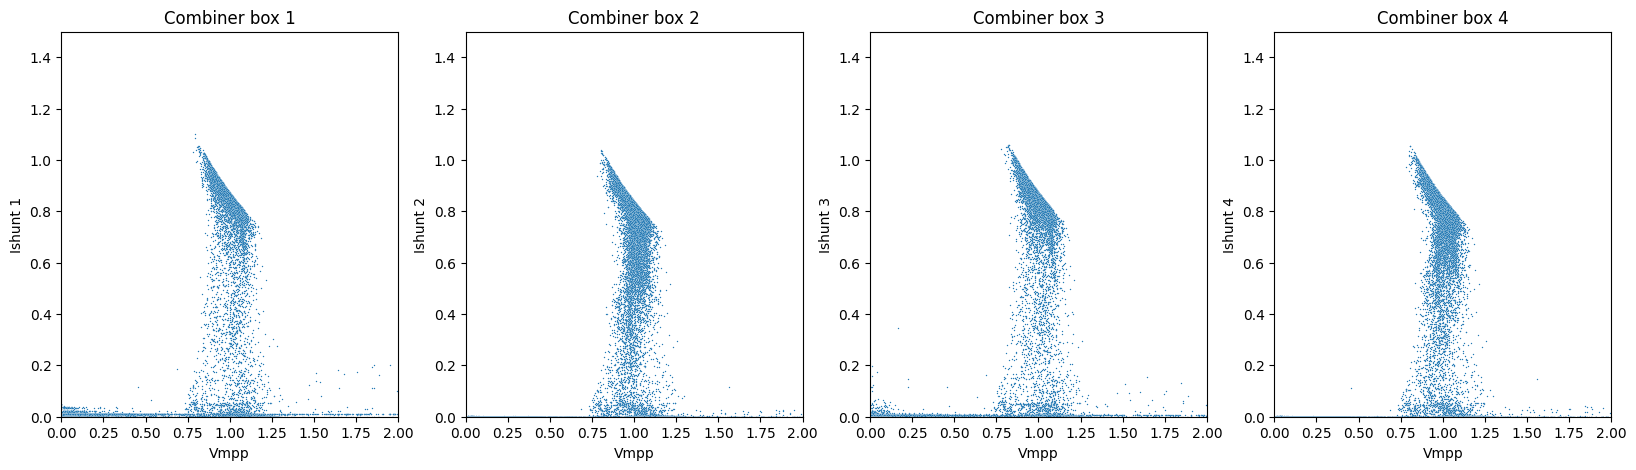

In [22]:
fig, ax = plt.subplots(1, len(fault_signatures_dict), figsize = (20, 5))

for i, (key, df_fault) in enumerate(fault_signatures_dict.items()):
    sns.scatterplot(data = df_fault.resample('30T').median(), x = 'Vmpp', y = f'Ishunt {key}', ax = ax[i], s = 1)
    ax[i].set_title(f'Combiner box {key}')
    ax[i].set_xlim(0, 2)
    ax[i].set_ylim(0, 1.5)

In [ ]:
std_threshold = 0.05
window = '60T'
min_samples = 30



                     Ishunt 1      Vmpp
TIMESTAMP                              
2015-01-01 08:16:00  0.113868  0.030790
2015-01-01 08:17:00  0.113412  0.030304
2015-01-01 08:18:00  0.115575  0.029842
2015-01-01 08:19:00  0.125168  0.029477
2015-01-01 08:20:00  0.135604  0.029057
                     Ishunt 2      Vmpp
TIMESTAMP                              
2015-01-01 08:14:00  0.118733  0.031761
2015-01-01 08:15:00  0.119175  0.031271
2015-01-01 08:16:00  0.118263  0.031327
2015-01-01 08:17:00  0.117293  0.030874
2015-01-01 08:18:00  0.118286  0.030422
                     Ishunt 3      Vmpp
TIMESTAMP                              
2015-01-01 08:16:00  0.128623  0.030790
2015-01-01 08:17:00  0.127667  0.030304
2015-01-01 08:18:00  0.129593  0.029842
2015-01-01 08:19:00  0.129593  0.029842
2015-01-01 08:20:00  0.129593  0.029842
                     Ishunt 4      Vmpp
TIMESTAMP                              
2015-01-01 08:15:00  0.119771  0.030290
2015-01-01 08:16:00  0.118978  0.030324


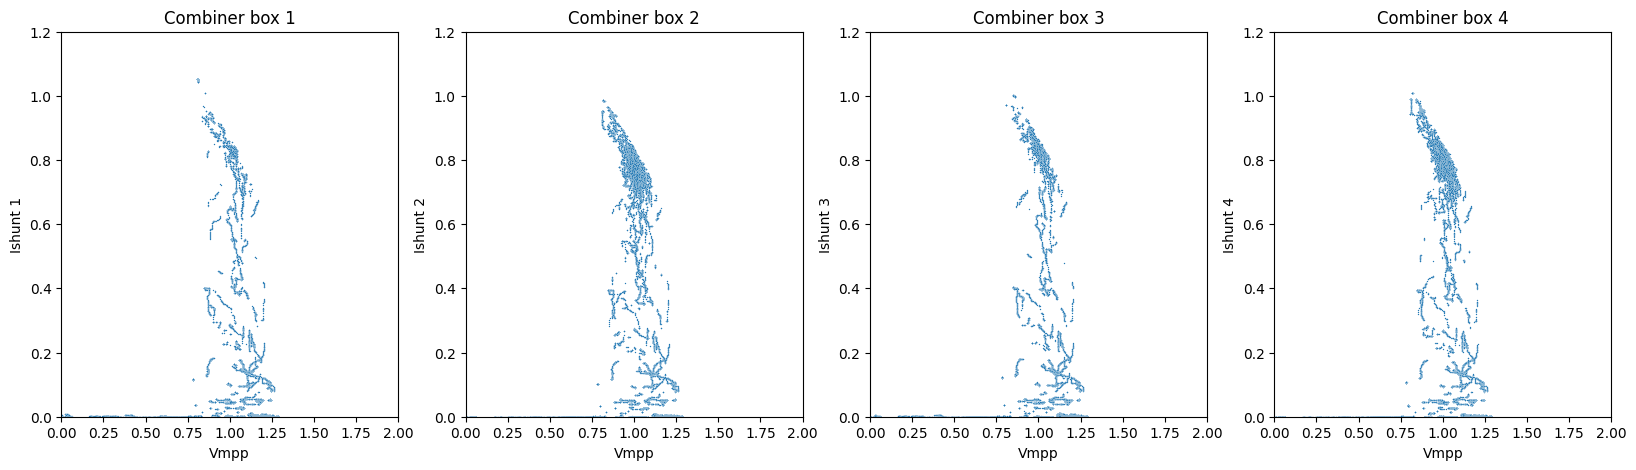

In [ ]:
fault_signatures_dict_clean = {}


for i in range(1, 5):
    df_fs_std = fault_signatures_dict[i].rolling(window, min_periods = min_samples, center = True).std().dropna()
    df_fs_median = fault_signatures_dict[i].rolling(window, min_periods = min_samples, center = True).median().dropna()


    df_fs_std['max_value'] = df_fs_std.apply(np.max, axis = 1)
    df_fs_std = df_fs_std.loc[df_fs_std['max_value'] < std_threshold]
    df_fs_clean = df_fs_median.loc[df_fs_median.index.isin(df_fs_std.index)]

    fault_signatures_dict_clean[i] = df_fs_clean.copy()




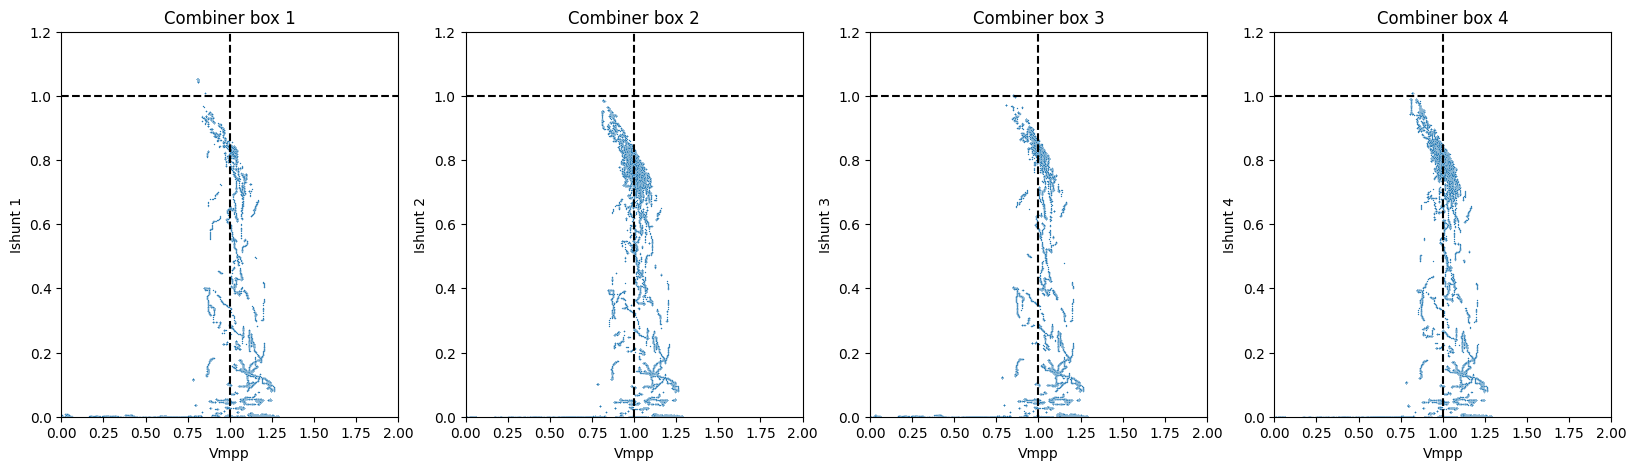

In [63]:

fig, ax = plt.subplots(1, len(fault_signatures_dict_clean), figsize = (20, 5))

for i, (key, df_fault) in enumerate(fault_signatures_dict_clean.items()):
    sns.scatterplot(data = df_fault, x = 'Vmpp', y = f'Ishunt {key}', ax = ax[i], s = 1)
    ax[i].set_title(f'Combiner box {key}')
    ax[i].set_xlim(0, 2)
    ax[i].set_ylim(0, 1.2)

    ax[i].axhline(1, c = 'black', linestyle = '--')
    ax[i].axvline(1, c = 'black', linestyle = '--')

In [64]:
def make_clusters(X, min_cluster_size=4, cluster_selection_epsilon=0.1):
    clusterer = HDBSCAN(min_cluster_size=min_cluster_size, cluster_selection_epsilon=cluster_selection_epsilon)
    labels = clusterer.fit_predict(X)
    return labels

Group 1 - Number of clusters: 11
Group 2 - Number of clusters: 11
Group 3 - Number of clusters: 9
Group 4 - Number of clusters: 9


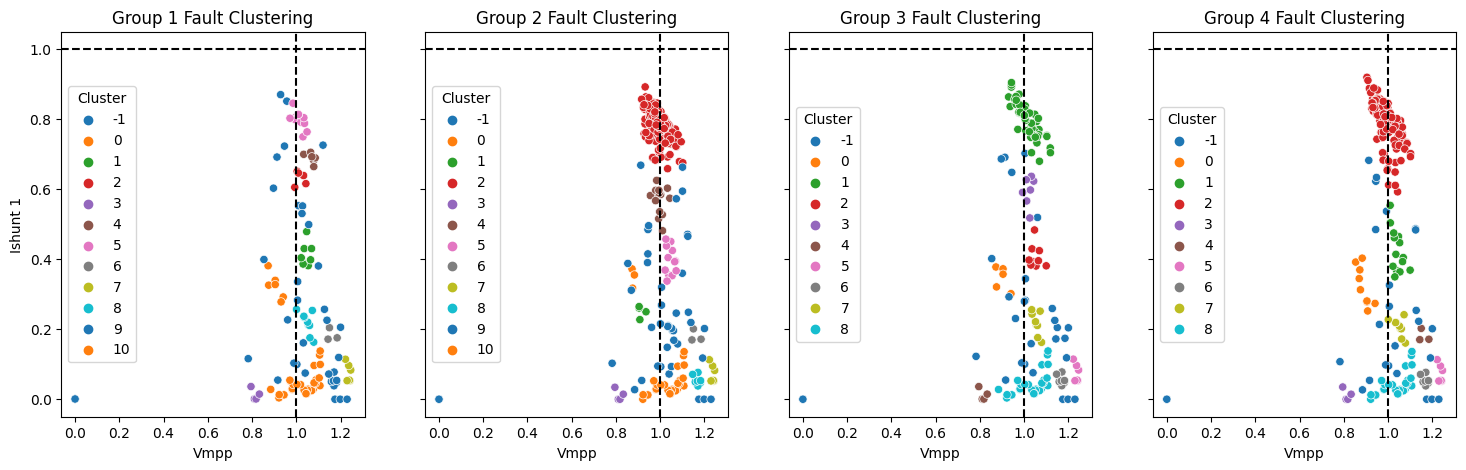

In [71]:
X_groups = {i: fault_signatures_dict_clean[i].resample('60T').median().dropna()[[f'Ishunt {i}', 'Vmpp']].loc['2015'] for i in range(1, 5)}

X_groups_labeled = X_groups.copy()

for i in X_groups:
    X_groups_labeled[i]['Cluster'] = make_clusters(X_groups[i], min_cluster_size=3, cluster_selection_epsilon = 0.04)
    print(f'Group {i} - Number of clusters: {len(set(X_groups_labeled[i]["Cluster"])) - (1 if -1 in X_groups_labeled[i]["Cluster"].values else 0)}')


fig, axes = plt.subplots(1, 4, figsize=(18, 5), sharex = True, sharey = True)
for i, ax in enumerate(axes, start=1):
    sns.scatterplot(data=X_groups_labeled[i], y=f'Ishunt {i}', x='Vmpp', hue='Cluster', palette='tab10', ax=ax,)
    ax.set_title(f'Group {i} Fault Clustering')
    ax.legend(title='Cluster', loc='best')
    ax.axhline(1, c = 'black', linestyle = '--')
    ax.axvline(1, c = 'black', linestyle = '--')

# Senario

We are in 2017, new fault happens

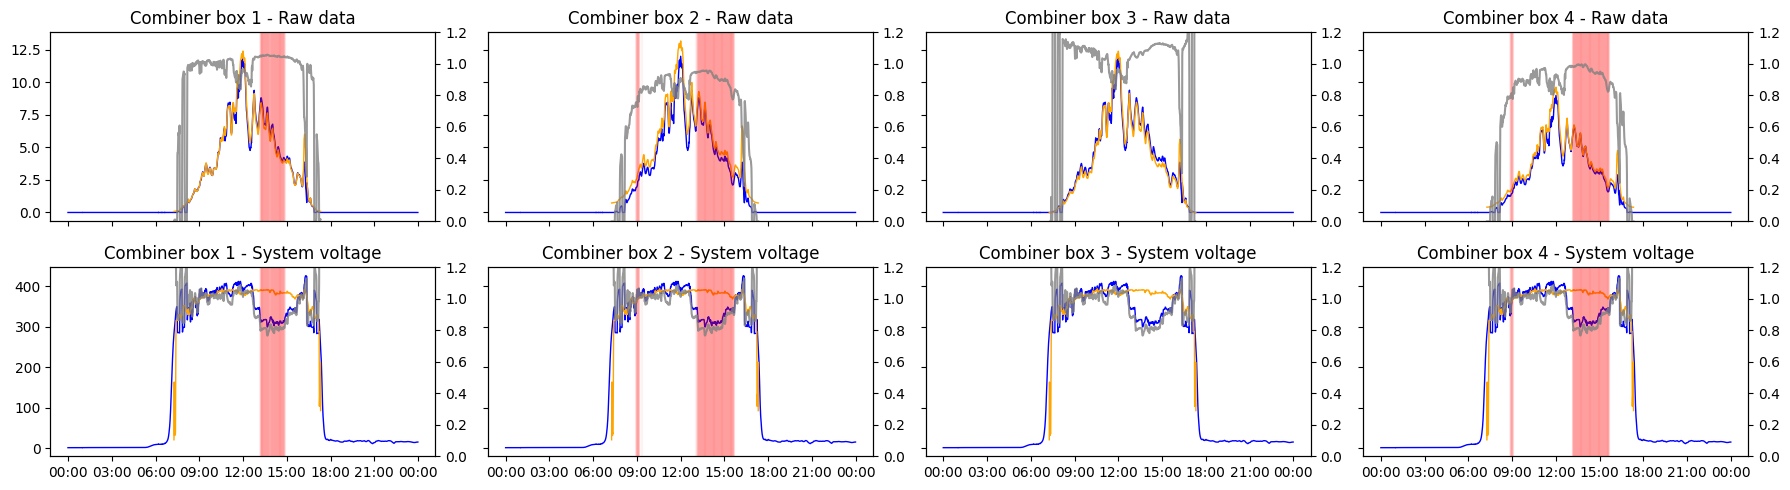

In [73]:
X_historical_dict = {i: fault_signatures_dict_clean[i].loc[:'2016'] for i in range(1, 5)}

new_fault_date = '2017-1-5'
fig, ax = plt.subplots(2, 4, figsize=(18, 5), sharex=True, sharey='row')

df_output_temp = df.loc[new_fault_date]
df_estimated_temp = df_predictions.loc[new_fault_date]
df_ratios_temp = df_ratios.loc[new_fault_date]
# df_fault_indexes = df_output_temp.loc[df_output_temp


for i in range(4):
    j = 0
    bc_index = i + 1
    ax[j, i].set_title(f'Combiner box {bc_index} - Raw data')
    ax[j, i].plot(df_output_temp[f'Ishunt {bc_index}'], label='Measured', color='blue', linewidth=1)
    ax[j, i].plot(df_estimated_temp[f'Ishunt {bc_index}'], label='Estimated', color='orange', linewidth=1)

    axt = ax[j, i].twinx()
    axt.plot(df_ratios_temp[f'Ishunt {bc_index}'], c = 'gray', alpha = 0.8)

    axt.set(ylim = (0, 1.2))

    j = 1
    ax[j, i].plot(df_output_temp[f'Vmpp'], label='Measured', color='blue', linewidth=1)
    ax[j, i].plot(df_estimated_temp[f'Vmpp'], label='Estimated', color='orange', linewidth=1)
    ax[j, i].set_title(f'Combiner box {bc_index} - System voltage')

    axt = ax[j, i].twinx()
    axt.plot(df_ratios_temp[f'Vmpp'], c = 'gray', alpha = 0.8)

    axt.set(ylim = (0, 1.2))

    for fault_index in fault_signatures_dict_clean[bc_index].loc[new_fault_date].index:
        ax[0, i].axvline(fault_index, c = 'red', alpha = 0.05)
        ax[1, i].axvline(fault_index, c = 'red', alpha = 0.05)



for row in ax:
    for axis in row:
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))


fig.tight_layout()

C:\Users\u0148831\AppData\Local\Temp\ipykernel_25208\3402838843.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fault['New fault'] = False
C:\Users\u0148831\AppData\Local\Temp\ipykernel_25208\3402838843.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fault['New fault'] = False
C:\Users\u0148831\AppData\Local\Temp\ipykernel_25208\3402838843.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

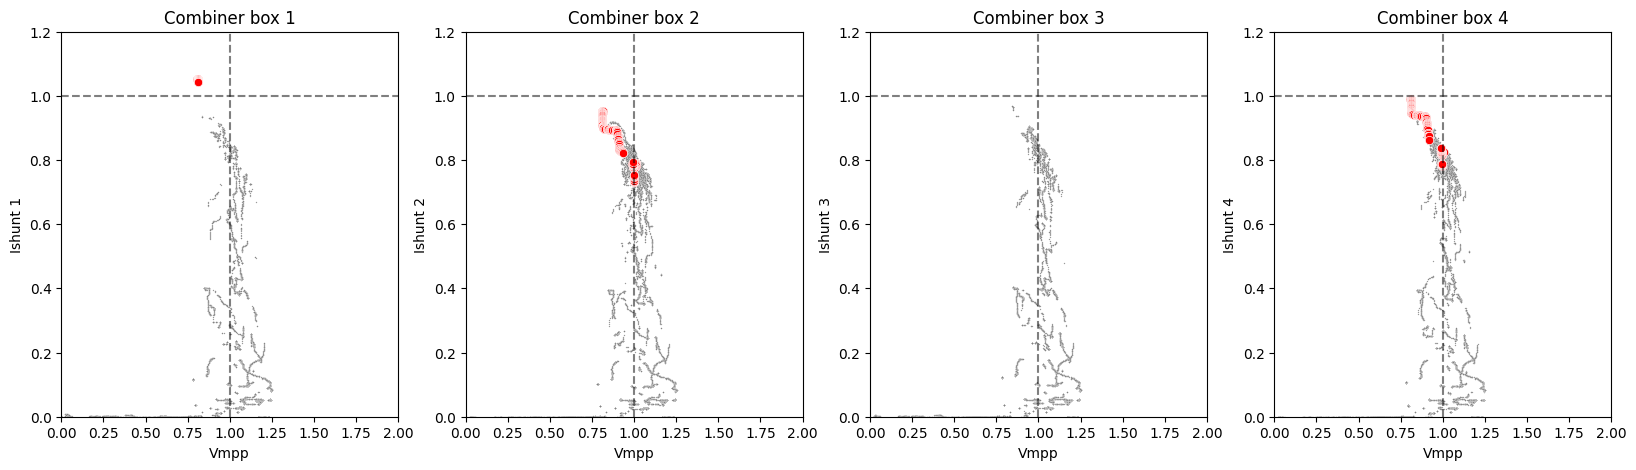

In [74]:
X_historical_updated = {i: fault_signatures_dict_clean[i].loc[:'2017-1-5'] for i in range(1, 5)}

df_investigation = X_historical_updated[1].copy()

df_investigation['New fault'] = False

df_investigation.loc[df_investigation.index > pd.to_datetime('2017-01-4'), 'New fault'] = True


fig, ax = plt.subplots(1, len(X_historical_updated), figsize = (20, 5))

for i, (key, df_fault) in enumerate(X_historical_updated.items()):

    df_fault['New fault'] = False

    df_fault.loc[df_fault.index > pd.to_datetime('2017-01-4'), 'New fault'] = True

    sns.scatterplot(data = df_fault.query('`New fault` == False'), x = 'Vmpp', y = f'Ishunt {key}', ax = ax[i], c = 'gray', alpha = 0.8, s = 1)
    sns.scatterplot(data = df_fault.query('`New fault` == True'), x = 'Vmpp', y = f'Ishunt {key}', ax = ax[i], c = 'red', alpha = 1, )

    ax[i].axvline(1, c = 'black', linestyle = '--', alpha = 0.5
                  )
    ax[i].axhline(1, c = 'black', linestyle = '--', alpha = 0.5
                  )
    ax[i].set_title(f'Combiner box {key}')
    ax[i].set_xlim(0, 2)
    ax[i].set_ylim(0, 1.2)